# Projet SY09 - Bigfoot

A FAIRE
* rajouter des commentaires
* essayer en complément des autres variables
* afficher l'accuracy en fonction du nombre de voisins
* utiliser les mêmes train_set pour les deux versions ?

## Import des bibiliothèques

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from datetime import datetime
import re
from collections import Counter, defaultdict

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from fog.tokenizers import WordTokenizer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from utils import plot_clustering, add_decision_boundary, plot_dendrogram, scatterplot_pca

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

## Préparation du jeu de données

In [2]:
# importer données du fichier csv
bigfoot = pd.read_csv("../data/bigfoot.csv", sep = ",")

### Features engineering

* https://www.kdnuggets.com/2018/12/feature-engineering-explained.html
* https://www.kdnuggets.com/2018/12/feature-building-techniques-tricks-kaggle.html

Changements par rapport au rapport intermédiaire :
* On retire toutes les classes C
* Comme on a pas de visualisation, on prend directement le numéro du mois pour avoir une variable numérique
* On a plus besoin de la variable date (elle est maintenant redondante avec les variables year, month et day)
* On ajoute les variables r et theta (coordonnées polaires) à partir de la latitude et longitude (dans le cas où les classes seraient en cercles concentriques)
* On encode les variables precip_type et season sur plusieurs variables (one-hot-encoding : chaque nouvelle variable est une valeur possible, et la valeur de cette variable est à 1 si c'est la valeur de la variable originelle, à 0 sinon)
* On supprime les variables precip_type et season

In [3]:
bigfoot = bigfoot[bigfoot.classification != "Class C"]

In [4]:
# ajoute des colonnes jour, mois, année
year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in bigfoot['date'].index:
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = d_datetime.month
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius
# wind_speed : miles par heure en kilomètre par heure
# precip_intensity : inch en cm
# visibility : miles en kilomètre
# latitude / longitude : coordonnées polaires
bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    wind_speed = bigfoot.wind_speed * 1.609344,
    precip_intensity = bigfoot.precip_intensity * 2.54,
    visibility = bigfoot.visibility * 1.609344,
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”
bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

# transformation de precip_type en deux colonnes snow et rain
# transformation de season en quatre colonnes
bigfoot["rain"] = 0.0
bigfoot.loc[bigfoot.precip_type == "rain", "rain"] = 1.0
bigfoot["snow"] = 0.0
bigfoot.loc[bigfoot.precip_type == "snow", "snow"] = 1.0
bigfoot["summer"] = 0.0
bigfoot.loc[bigfoot.season == "Summer", "summer"] = 1.0
bigfoot["spring"] = 0.0
bigfoot.loc[bigfoot.season == "Spring", "spring"] = 1.0
bigfoot["fall"] = 0.0
bigfoot.loc[bigfoot.season == "Fall", "fall"] = 1.0
bigfoot["winter"] = 0.0
bigfoot.loc[bigfoot.season == "Winter", "winter"] = 1.0

bigfoot.drop(columns="geohash", inplace=True)
bigfoot.drop(columns="date", inplace=True)
bigfoot.drop(columns=["precip_type"], inplace=True)

### Typage des variables

Changements par rapport au rapport intermédiaire :
* day, month, year castés à float pour éviter d'avoir les nan spécifiques aux entiers

In [5]:
# dictionnaire des états des Etats-Unis et leur abbrévation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# variables catégorielles
# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.
bigfoot.county = pd.Categorical(bigfoot.county)
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())
bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B"], ordered=True)

bigfoot.observed = bigfoot.observed.astype('str')
bigfoot.location_details = bigfoot.location_details.astype('str')
bigfoot.title = bigfoot.title.astype('str')
bigfoot.summary = bigfoot.summary.astype('str')
bigfoot.number = bigfoot.number.astype('Int64')
bigfoot.day = bigfoot.day.astype(float)
bigfoot.month = bigfoot.month.astype(float)
bigfoot.year = bigfoot.year.astype(float)

### Observer les corrélations pour supprimer des variables

<Axes: >

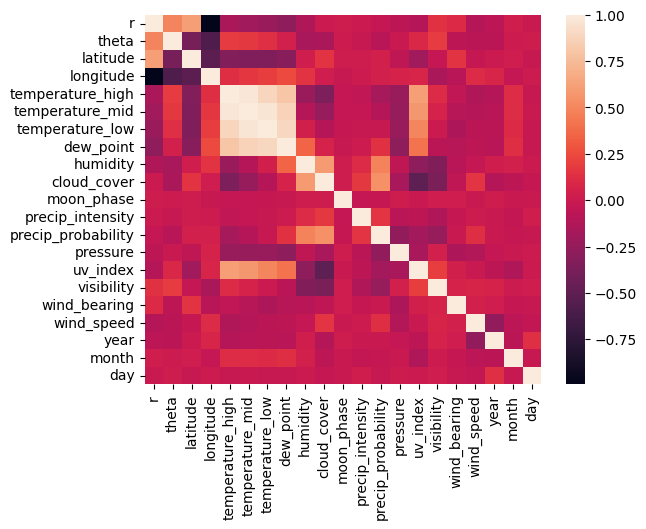

In [6]:
features = [
    'r',
    'theta',
    'latitude',
    'longitude',
    'temperature_high',
    'temperature_mid',
    'temperature_low',
    'dew_point',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

corr = bigfoot[features].corr()
sns.heatmap(corr)

<Axes: >

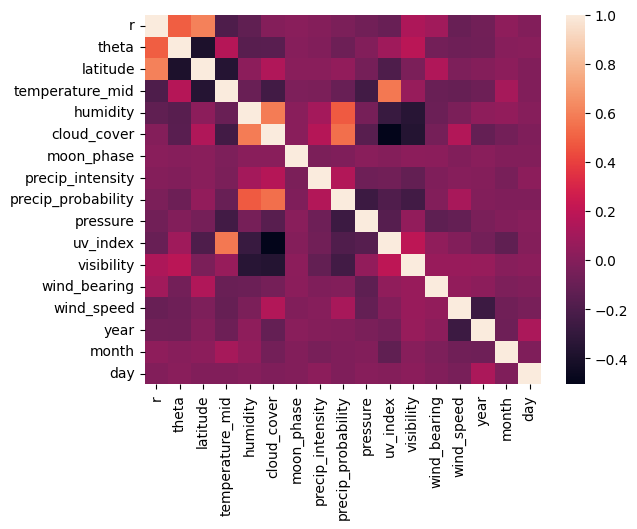

In [7]:
features = [
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]
corr = bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point", "longitude"])[features].corr()
sns.heatmap(corr)

In [8]:
bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point"], inplace=True)

features = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

cat_cols = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
]

num_cols = [
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
]

## Traiter le texte

In [9]:
def fill_missing(df):
    '''
    replace empty values by column's mean in dataframe
    '''
    return df.copy().fillna(df.mean())

In [10]:
def calculate_zscore(df):
    '''
    scales columns in dataframe using z-score
    '''
    df = df.copy()
    for col in df.columns:
        if df[col].std(ddof=0) == 0:
            df[col] = (df[col] - df[col].mean())
        else:
            df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

    return df

In [11]:
def normalize_column_modality(df):
    '''
    divides each column by the probability μₘ of the modality 
    (number of ones in the column divided by N) only for one hot columns
    '''
    df = df.copy()
    length = len(df)
    for col in df.columns:
        weight = math.sqrt(sum(df[col])/length)
        df[col] = df[col]/weight

    return df

In [12]:
stop_list = ["me", "'m", "while", "near", "'re", "'s", 'report', 'person', 'smh', 'it', 'great', 'there', 'days', 'hate', 'look', 'most', 'phone', 'well', 'watch', "'ve", 'm', 'by', 'cause', 'got', 'out', 'too', 'will', 't', 'get', 'video', 'keep', 'care', 'song', 'd', 'mean', 'was', 'he', 'miss', 'such', 'damn', 'is', 'house', 'a', 'into', 'am', 'been', 'im', 'much', 'one', 'just', 'are', 'really', 'sleep', 'team', 'want', 'work', 'photo', 'gotta', 'its', 'niggas', 'because', 'home', 'already', 'better', 'new', 'now', '3', 'off', 'made', 'over', 'your', 'only', 'tweet', 'week', 'she', 'this', 'didn', 'does', 'god', 'ever', 'dont', 'gonna', "i'", 'after', 'and', 'hard', 'help', 'how', 'in', 'their', 'any', 'him', 'bout', 'never', 'when', 'if', 'take', 'everyone', 'something', 'what', 'talk', "won't", 'they', 's', 'so', 'can', 'show', 'r', 'next', 'tell', 'them', 'guys', 'again', 'than', 'before', 'nigga', 'p', 'thing', 'g', 'w', 'friends', 'best', 'being', 'life', 'said', 'the', 'i', 'l', 'more', 'should', 'play', 'ross', 'someone', 'think', 'on', 'were', 'where', 'far', 'fuck', 'right', 'with', 'school', 'her', 'about', '2012', 'put', 'way', 'fucking', 'twitter', 'back', 'would', 'don', 'or', 'us', 'to', 'e', 'free', 'need', 'thank', 'who', '0', 'hip', 'every', 'gone', 'o', 'bad', 'head', 'at', 'ass', 'ready', 'day', 'll', 'heart', 'his', 'time', "'d", "'ll", 'my', 'f', 'all', 'has', 've', 'other', 'going', 'having', 'shit', 'an', 'go', 'wait', 'did', 'like', 'many', 'follow', 'last', 'morning', 'we', 'away', 'tomorrow', 'you', 'cool', 'no', 'that', 'feel', 'here', 'real', 'had', "don't", 'do', 're', 'live', "can't", 'news', 'lt', 'today', 'love', 'why', 'world', 'check', 'still', 'for', 'know', 'see', 'wish', 'have', 'cant', 'give', 'things', 'two', 'down', 'stop', 'say', 'class', 'done', 'thanks', 'looking', 'up', 'be', 'start', 'find', 'nothing', '1', 'tho', 'though', '2', 'won', 'another', 'hair', 'watching', 'please', 'make', 'then', 'even', 'people', 'let', 'year', 'everything', 'h', 'big', 'girls', 'wanna', 'could', 'from', 'our', 'ain', 'but', 'c', 'doing', 'hop', 'old', 'some', 'of', 'good', 'nice', 'n', 'b', 'as', 'money', 'girl', 'around', 'u', 'face', 'bitch', 'not', 'game', 'always', 'j', 'long', 'lmao', 'same', 'k', 'little', 'getting', 'win', 'these', 'hope', 'amp', 'tonight', 'man', 'come']
NUMBER_PARENTHESIS = re.compile(r"[0-9\(\)]")

tokenizer = WordTokenizer(lower=True, unidecode=True, drop=["punct", "number"], stoplist=stop_list)

IDF -> si le terme est important pour le document. Plus c'est grand, plus le terme est spécifique au document.

TF -> à quel point le terme est présent au sein du document.

Pour les variables python finissant en class, on considère qu'un document correspond à l'ensemble des textes de la classe

In [13]:
tokens_series = bigfoot.observed.copy()
tokens = Counter()
tokens_per_report = defaultdict(Counter)
tokens_per_class = defaultdict(Counter)
report_per_token = defaultdict(set)
class_per_token = defaultdict(set)
TF = defaultdict(Counter)

for i in bigfoot[:].index:
    if bigfoot["observed"][i] == "nan":
        continue
    tokens_series[i] = "|".join([i for _, i in tokenizer.tokenize(bigfoot["observed"][i])])
    for _, token in tokenizer.tokenize(bigfoot["observed"][i]):
        if not NUMBER_PARENTHESIS.search(token):
            tokens[token] += 1
            tokens_per_report[bigfoot["number"][i]][token] += 1
            tokens_per_class[bigfoot["classification"][i]][token] += 1
            report_per_token[token].add(bigfoot["number"][i])
            class_per_token[token].add(bigfoot["classification"][i])
    for _, token in tokenizer.tokenize(bigfoot["observed"][i]):
        if sum(i for _, i in tokens_per_report[bigfoot["number"][i]].most_common()) != 0:
            # nombre de fois que le token est présent dans le rapport / nombre de tokens du rapport
            TF[bigfoot["number"][i]][token] = tokens_per_report[bigfoot["number"][i]][token] / sum(i for _, i in tokens_per_report[bigfoot["number"][i]].most_common())

bigfoot = bigfoot.assign(tokens = tokens_series)

In [14]:
tokens_per_class["A"].most_common(10)

[('saw', 4135),
 ('road', 3474),
 ('very', 3081),
 ('looked', 2500),
 ('area', 2364),
 ('feet', 2284),
 ('creature', 2267),
 ('heard', 1973),
 ('side', 1942),
 ('woods', 1908)]

In [15]:
tokens_per_class["B"].most_common(10)

[('heard', 5396),
 ('very', 3058),
 ('area', 2932),
 ('sound', 2394),
 ('night', 2324),
 ('woods', 2243),
 ('went', 2098),
 ('road', 2093),
 ('saw', 1917),
 ('thought', 1495)]

In [16]:
IDF = Counter()
for index_most, token in enumerate(tokens):
    if len(report_per_token[token]) != 0:
        # log( nombre de témoignages / nombre de témoignages où apparaît le token )
        IDF[token] = math.log( bigfoot.shape[0] / len(report_per_token[token]) )

In [17]:
IDF.most_common(10)

[('sipsey', 8.515391569469609),
 ('bogfoots', 8.515391569469609),
 ('tundra', 8.515391569469609),
 ('u.r.i', 8.515391569469609),
 ('mealbook', 8.515391569469609),
 ('comig', 8.515391569469609),
 ('perhads', 8.515391569469609),
 ('all-in-one', 8.515391569469609),
 ('phenominal', 8.515391569469609),
 ('improbable', 8.515391569469609)]

In [18]:
pd.DataFrame(tokens_per_class["A"].most_common(200))

,0,1
0,saw,4135
1,road,3474
2,very,3081
3,looked,2500
4,area,2364
...,...,...
195,thinking,328
196,during,325
197,clear,321
198,must,321


<Axes: xlabel='0'>

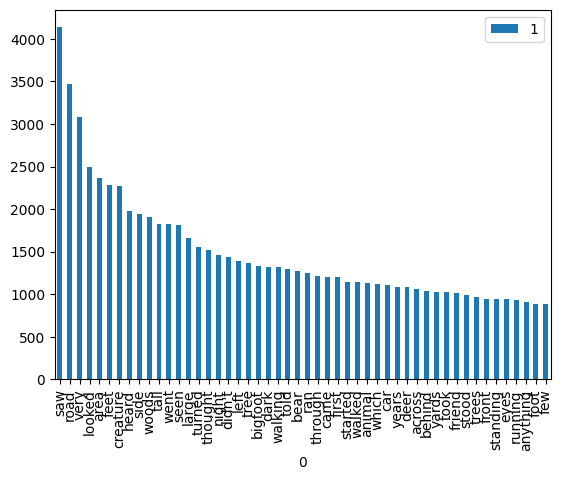

In [19]:
pd.DataFrame(tokens_per_class["A"].most_common(50)).plot.bar(x=0, y=1)

<Axes: xlabel='0'>

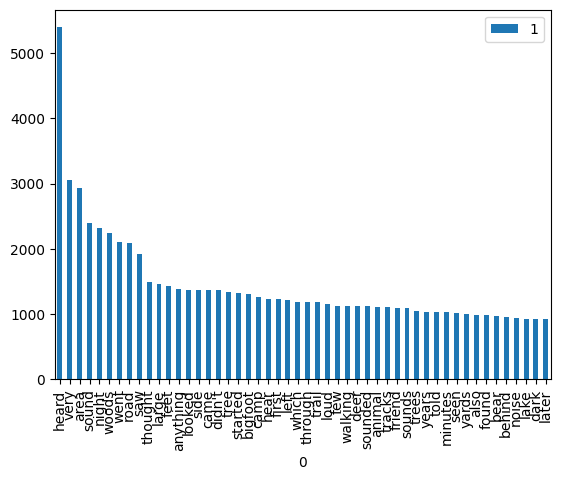

In [20]:
pd.DataFrame(tokens_per_class["B"].most_common(50)).plot.bar(x=0, y=1)

In [21]:
# les 10 tokens les plus présents pour chaque classe
tokens_to_use = set([i for i, _ in tokens_per_class["A"].most_common(10)] + [i for i, _ in tokens_per_class["B"].most_common(10)])

In [22]:
tokens_to_use

{'area',
 'creature',
 'feet',
 'heard',
 'looked',
 'night',
 'road',
 'saw',
 'side',
 'sound',
 'thought',
 'very',
 'went',
 'woods'}

In [23]:
# TF-IDF
TF_IDF = defaultdict(Counter)
for index_bigfoot in bigfoot[:].index:
    for index_most, token in enumerate(tokens_to_use):
        TF_IDF[bigfoot["number"][index_bigfoot]][token] = TF[bigfoot["number"][index_bigfoot]][token] * IDF[token]

In [24]:
most_present_columns_0_1 = [bigfoot.observed.copy() for i in tokens_to_use]
most_present_columns_TF_IDF = [bigfoot.observed.copy() for i in tokens_to_use]

### One-hot-encoding (on essaye en codant 0 et 1 dans les colonnes des mots)

In [25]:
# Pour chaque token selectionné, on ajoute une colonne one-hot encoding
for index_bigfoot in bigfoot[:].index:
    for index_most, token in enumerate(tokens_to_use):
        if token in tokens_per_report[bigfoot["number"][index_bigfoot]]:
            most_present_columns_0_1[index_most][index_bigfoot] = 1
        else:
            most_present_columns_0_1[index_most][index_bigfoot] = 0

for index_most, token in enumerate(tokens_to_use):
    bigfoot[token] = most_present_columns_0_1[index_most]

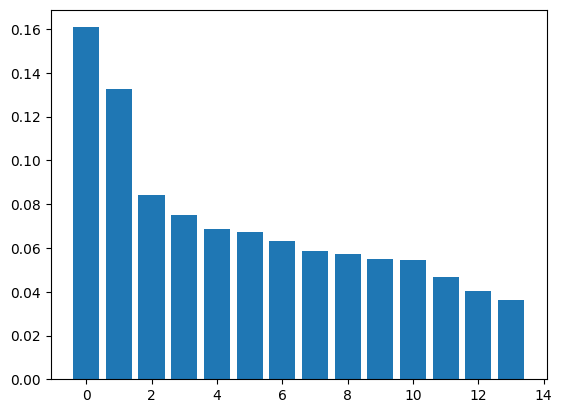

In [26]:
bigfoot_famd = normalize_column_modality(bigfoot[list(tokens_to_use)])
cls = PCA()
pcs = cls.fit_transform(bigfoot_famd)
plt.bar(range(cls.components_.shape[0]), cls.explained_variance_ratio_)
plt.show()

In [27]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(cls.explained_variance_.size)], 
        "Variance expliquée" : cls.explained_variance_,
        "% variance expliquée" : np.round(cls.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(cls.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,1.318458,16.0,16.0
1,Dim2,1.085986,13.0,29.0
2,Dim3,0.688640,8.0,38.0
3,Dim4,0.616153,8.0,45.0
4,Dim5,0.564235,7.0,52.0
5,Dim6,0.549832,7.0,59.0
6,Dim7,0.519564,6.0,65.0
7,Dim8,0.480112,6.0,71.0
8,Dim9,0.468046,6.0,77.0
9,Dim10,0.450089,5.0,82.0


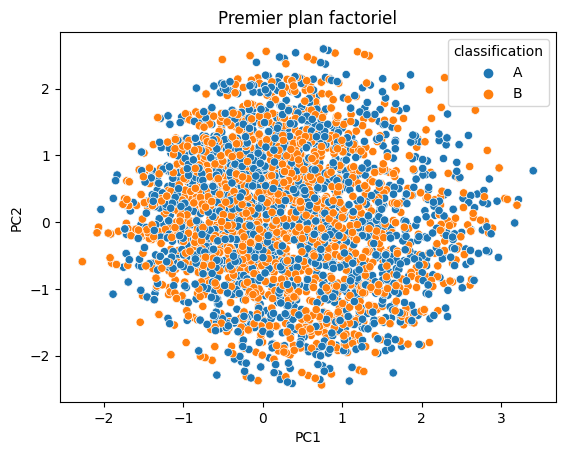

In [28]:
df_X = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(cls.components_.shape[0])])
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X)
plt.title("Premier plan factoriel")
plt.show()

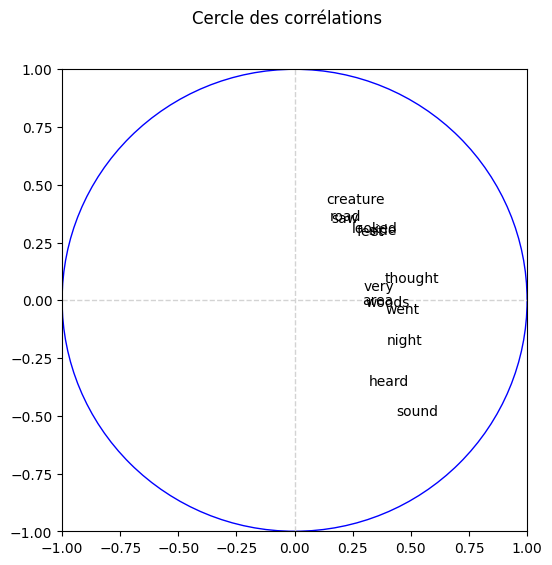

In [29]:
n = bigfoot_famd.shape[0] # nb individus
p = bigfoot_famd.shape[1] # nb variables
eigval = (n-1) / n * cls.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = cls.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': list(tokens_to_use), 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

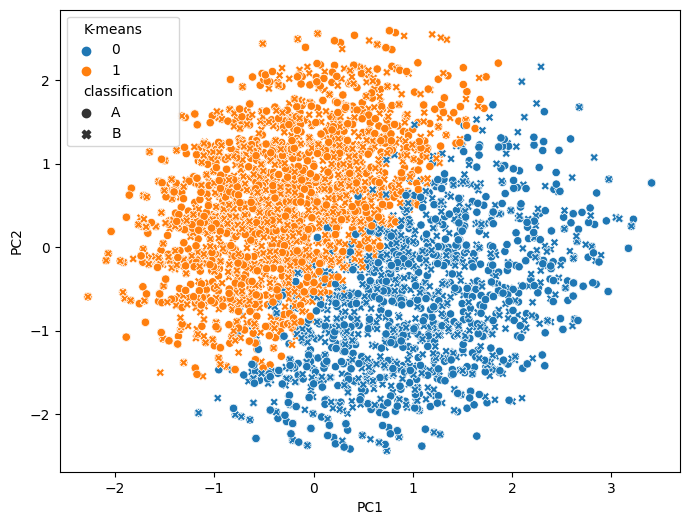

In [30]:
kmeans3 = KMeans(n_clusters=2, n_init=10)
kmeans3.fit(bigfoot_famd)
plt.figure(figsize=(8,6))
labels = pd.Series(kmeans3.labels_, name="K-means")
ax, _ = scatterplot_pca(data=bigfoot_famd, hue=labels, style=bigfoot.classification)
plt.show()
fig = ax.get_figure()

In [31]:
# Séparer le jeu de donnéees
X_train, X_test, y_train, y_test = train_test_split(bigfoot_famd, bigfoot.classification, train_size=0.66)

In [32]:
# validation croisées pour trouver le meilleur nombre de voisins

# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test), search.best_params_

(0.7195050088391278, {'n_neighbors': 172})

In [33]:
models = [
    (LinearDiscriminantAnalysis, "LDA"),
    (QuadraticDiscriminantAnalysis, "QDA"),
    (GaussianNB, "NB"),
    (LogisticRegression, "LREG"),
    (DecisionTreeClassifier, "Tree")
]

def validation_errors(X, y, models):
    for model, name in models:
        for acc in cross_val_score(model(), X, y, cv=10):
            yield name, acc

def add_decision_boundaries(df, models):
    colors = sns.color_palette()
    for model, name in models:
        y = df.classification
        X = df.drop(columns=["classification"])
        cls = model()
        cls.fit(X, y)
        add_decision_boundary(cls, label=name, color=colors.pop(), region=False)

/tmp/ipykernel_7891/1076902694.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="Model", y="Acc", data=df, ci="sd")


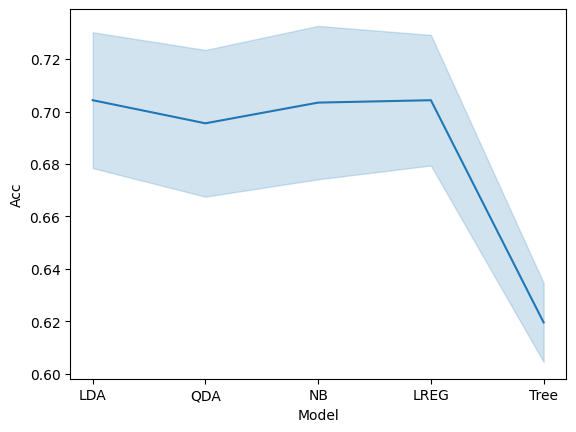

In [34]:
df = pd.DataFrame(validation_errors(X_train, y_train, models), columns=["Model","Acc"])
sns.lineplot(x="Model", y="Acc", data=df, ci="sd")
plt.show()

### TF-IDF dans la colonne à la place de 0 et 1

In [35]:
for index_bigfoot in bigfoot[:].index:
    for index_most, token in enumerate(tokens_to_use):
        most_present_columns_TF_IDF[index_most][index_bigfoot] = TF_IDF[bigfoot["number"][index_bigfoot]][token]

for index_most, token in enumerate(tokens_to_use):
    bigfoot[token] = most_present_columns_TF_IDF[index_most]

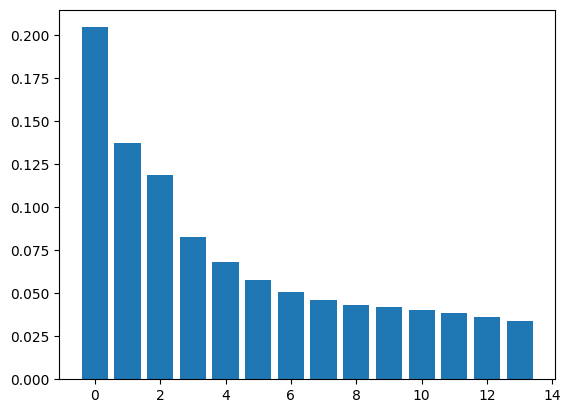

In [36]:
bigfoot_famd = bigfoot[list(tokens_to_use)]
cls = PCA()
pcs = cls.fit_transform(bigfoot_famd)
plt.bar(range(cls.components_.shape[0]), cls.explained_variance_ratio_)
plt.show()

In [37]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(cls.explained_variance_.size)], 
        "Variance expliquée" : cls.explained_variance_,
        "% variance expliquée" : np.round(cls.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(cls.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,0.000351,20.0,20.0
1,Dim2,0.000236,14.0,34.0
2,Dim3,0.000203,12.0,46.0
3,Dim4,0.000142,8.0,54.0
4,Dim5,0.000117,7.0,61.0
5,Dim6,0.000099,6.0,67.0
6,Dim7,0.000087,5.0,72.0
7,Dim8,0.000079,5.0,77.0
8,Dim9,0.000074,4.0,81.0
9,Dim10,0.000072,4.0,85.0


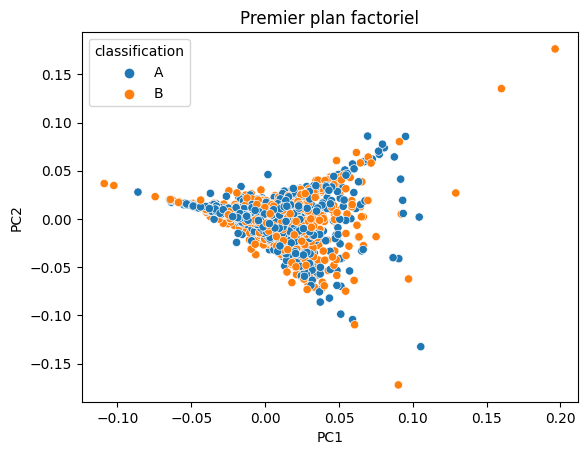

In [38]:
df_X = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(cls.components_.shape[0])])
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X)
plt.title("Premier plan factoriel")
plt.show()

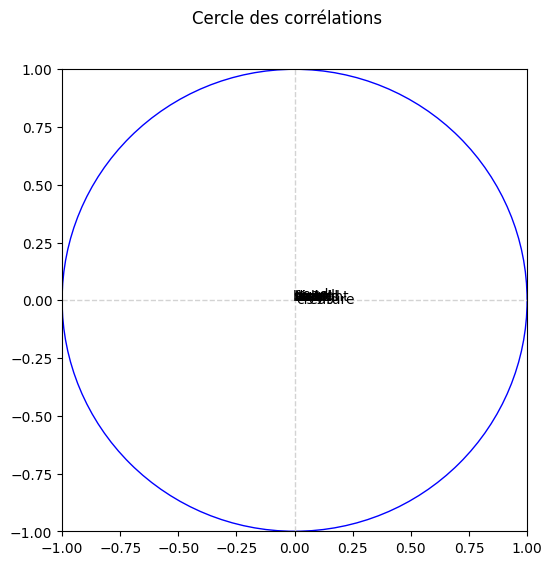

In [39]:
n = bigfoot_famd.shape[0] # nb individus
p = bigfoot_famd.shape[1] # nb variables
eigval = (n-1) / n * cls.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = cls.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': list(tokens_to_use), 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

In [40]:
# Séparer le jeu de donnéees
X_train, X_test, y_train, y_test = train_test_split(bigfoot_famd, bigfoot.classification, train_size=0.66)

In [41]:
# validation croisées pour trouver le meilleur nombre de voisins

# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test), search.best_params_

(0.7307012374779022, {'n_neighbors': 500})